In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt
import random
import pandas as pd

import os, sys
root = os.getcwd()
print(root)



In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import normal





In [ ]:
from torch.optim import lr_scheduler
print(torch)

In [2]:
%reload_ext autoreload
from models.util import *



loaded


In [ ]:
def plot_save_disk(x,y, filename, xmax=64, ymax=64):
	x =  np.arange(0,10,0.1)
	y = np.cos(x)
	fig = plt.figure(frameon=False, figsize=(xmax, ymax), dpi=1 )

	ax = plt.Axes(fig, [0., 0., 1., 1.])
	ax.set_axis_off()
	fig.add_axes(ax)
	plt.plot(x,y, c="black", linewidth=100 )
	fig.savefig(filename)
    



In [ ]:
folder= root + "/../adata/sinus/64_64/"
amp_i = 3
omega_i= 2
type_i =1

x,y = generate_random_sin(1, amp_i, 4, omega_i, 0.1)
# print(x,y)
filename = f'{folder}/sin_{amp_i}-{omega_i}-{type_i}.png'
        
plot_save_disk(x,y, filename, xmax=64, ymax=64)



/home/ubuntu/proj/_generator/a/models/util.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(frameon=False, figsize=(xmax, ymax), dpi=1)


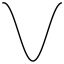

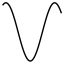

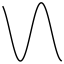

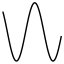

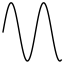

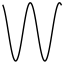

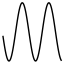

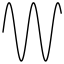

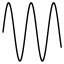

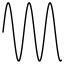

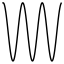

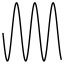

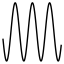

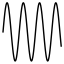

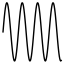

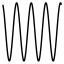

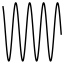

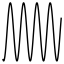

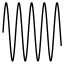

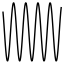

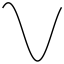

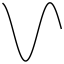

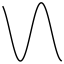

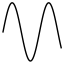

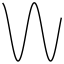

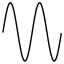

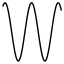

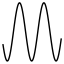

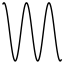

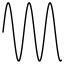

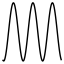

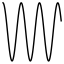

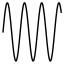

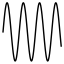

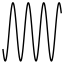

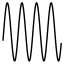

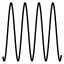

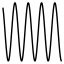

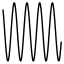

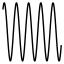

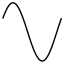

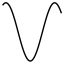

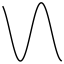

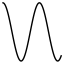

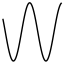

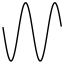

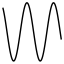

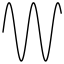

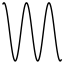

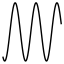

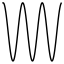

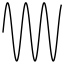

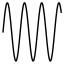

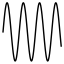

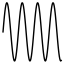

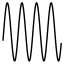

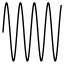

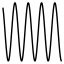

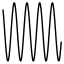

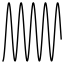

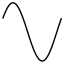

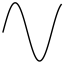

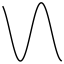

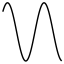

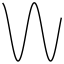

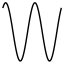

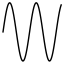

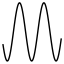

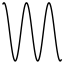

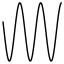

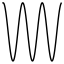

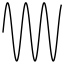

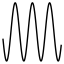

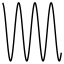

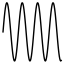

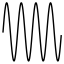

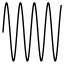

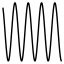

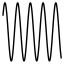

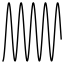

In [3]:
generate_train_img( folder= root + "/../adata/sinus/64_64/",
                    N_type=4, amax=2, wmin=5, wmax=25, wfreq=0.1 ) 




# Testing sine generation

In [ ]:
def generate_random_sin(n_rand_starts = 100, amplitude = 1, n_pis = 4, omega = 1, step = 0.1):
  r = np.random.randint(n_rand_starts)

  x = np.arange(r, r + n_pis*np.pi, step)   # start,stop,step
  y = amplitude * np.sin(omega * x)

  return y

In [ ]:
plt.figure()
plt.plot(generate_random_sin(100, 1, 4, 1, 0.1))
plt.show()

# Generating dataset with different properties

In [ ]:
N_type = 100
X = []

for type_i in range(N_type):
  for amp_i in range(1,5): # different amplitude
    for omega_i in range(1, 5): # different omega
      X.append(generate_random_sin(N_type, amp_i, 4, omega_i, 0.1))

In [ ]:
X = np.array(X)
Y = np.zeros(len(X))

In [ ]:
X.shape, Y.shape

In [ ]:
plt.figure()
for x in X[:10]:
    plt.plot(x)
plt.show()

In [ ]:
import torch.utils.data as utils

train = torch.utils.data.TensorDataset(torch.Tensor(X), torch.Tensor(Y))
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

### Defining models

In [ ]:
nn_dim = 100
nn_dim2 = 50
latent_dim = 4
img_shape = len(X[0])

N, M = 2, int(latent_dim / 2)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(img_shape, nn_dim)
        self.fc2 = nn.Linear(nn_dim, nn_dim2)
        
        self.fc21 = nn.Linear(nn_dim2, latent_dim)
        self.fc22 = nn.Linear(nn_dim2, latent_dim)
        
        self.fc3 = nn.Linear(latent_dim, nn_dim2)
        self.fc4 = nn.Linear(nn_dim2, nn_dim)
        self.fc5 = nn.Linear(nn_dim, img_shape)

    def encode(self, x):
        h1 = F.leaky_relu(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def reparameterize_static(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return std.add_(mu)

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z))
        h4 = F.leaky_relu(self.fc4(h3))
        return self.fc5(h4)
#         return torch.tanh(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, img_shape))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def visualize(model, latent_dim, rangee):
    viz = []
    
    random_index = np.random.randint(len(X)-1)
    X_random = X[random_index]
    zi, zi_std = model.encode(torch.Tensor(X_random))
    
#     zi = torch.randn(latent_dim)
    
    for j in range(latent_dim):    
        buf = []   
        for i in rangee:
            x = zi.clone()
            x[j] += i
            zi2 = torch.zeros(latent_dim)
            gen_imgs = model.decode(model.reparameterize_static(x, zi2))
            gen_imgs_np = gen_imgs.data.numpy()
            buf.append(gen_imgs_np)
        viz.append(buf)
    
    fig, axs = plt.subplots(M, N, sharex=True, sharey=True, figsize=(int(N*3), int(M*3)))
    
    k = 0
    for i in range(M):
        for j in range(N):
            axs[i, j].plot(X_random, ls = '--', color = 'black')

            ts = np.array(viz[k]).T
            axs[i, j].plot(ts[:, 0], lw = 3, color = 'blue')
            axs[i, j].plot(ts[:, 1], lw = 3, color = 'black')
            axs[i, j].plot(ts[:, 2], lw = 3, color = 'red')
            k += 1
    plt.show()
    

def visualize_beat_reconstruction(X, model):
    I = torch.randint(len(X)-1, (1, ))
    x_input = torch.Tensor(np.array([X[I]]))
    x_vector = model.encode(x_input)
    x_reconstruct = model.decode(model.reparameterize(x_vector[0], x_vector[1]))

    plt.figure()
    plt.title('Random reconstructed sample')
    plt.plot(X[I])
    plt.plot(x_reconstruct.data.numpy()[0])
    plt.show()

# Training models

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x.view(-1, img_shape), reduction='sum')
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, img_shape), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [ ]:
epochs = 100
beta = 10

C, C_final = 0, 50
C_stop = epochs #25
C_delta = (1 / C_stop) * C_final

In [ ]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        try:
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)
            BCE, KLD = BCE / len(data), KLD / len(data)
            
            loss = BCE + beta * torch.abs(KLD - C)
            
            loss.backward()
            optimizer.step()
        except:
            continue
            
        if epoch > C_stop:
            C = C_final

#     if epoch % 10 == 0:                
    print('Epoch', str(epoch), 
          '| BCE', BCE.data.numpy(), 
          '| KL', KLD.data.numpy(), 
          '| C', C, 
          '| (KL-C) * beta', torch.abs(KLD - C).data.numpy() * beta, 
          '| Loss', loss.data.numpy())

    visualize(model, latent_dim, np.arange(-3, 3.5, 1.5))

    C += C_delta

# Evaluation

In [ ]:
viz = []
random_index = np.random.randint(len(X)-1)
X_random = X[random_index]
zi, zi_std = model.encode(torch.Tensor(X_random))
# zi = torch.randn(latent_dim)
for j in range(latent_dim):    
    buf = []   
    for i in np.arange(-3, 3, 0.25):
        x = zi.clone()
        x[j] += i
        zi2 = torch.zeros(latent_dim)
        gen_imgs = model.decode(model.reparameterize_static(x, zi2))
        gen_imgs_np = gen_imgs.data.numpy()
        buf.append(gen_imgs_np)
    viz.append(buf)

fig, axs = plt.subplots(M, N, sharex=True, sharey=True, figsize=(int(N*3), int(M*3)))

k = 0
for i in range(M):
    for j in range(N):
        axs[i, j].plot(X_random, ls = '--', color = 'black')
        
        ts = np.array(viz[k]).T
        axs[i, j].plot(ts[:, 0], lw = 2, color = 'blue')
        axs[i, j].plot(ts[:, 1], lw = 2, color = 'blue')
        axs[i, j].plot(ts[:, 2], lw = 2, color = 'black')
        axs[i, j].plot(ts[:, 3], lw = 2, color = 'red')
        axs[i, j].plot(ts[:, 4], lw = 2, color = 'red')
        k += 1
plt.show()